In [1]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from termcolor import colored

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.metrics import SparseCategoricalAccuracy, Mean

In [2]:
train_ds, ds_info = tfds.load(
                              name='mnist',
                              as_supervised=True,
                              split='train',
                              shuffle_files=True,
                              with_info=True
)

In [3]:
def normalization(images, labels):
  images = tf.cast(images, tf.float32) / 255.
  return [images, labels]

In [4]:
n_layer = 20
activation = 'relu'
cmap = cm.get_cmap('rainbow', lut=n_layer + 1)
units = [10] * n_layer

In [5]:
model = Sequential()
model.add(Flatten())
for layer_idx in range(n_layer - 1):
  model.add(Dense(units=units[layer_idx], activation=activation))
model.add(Dense(units=10, activation='softmax'))

model.build(input_shape=(None, 28, 28, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1

In [6]:
train_batch_size = 10
train_ds = train_ds.map(normalization).batch(train_batch_size)

In [7]:
loss_object = SparseCategoricalCrossentropy()
optimizer = SGD()

In [8]:
train_ds_iter = iter(train_ds)
images, labels = next(train_ds_iter)
print(images.shape, labels.shape)

(10, 28, 28, 1) (10,)


In [9]:
with tf.GradientTape() as tape:
  predictions = model(images)
  loss = loss_object(labels, predictions)

gradients = tape.gradient(loss, model.trainable_variables)

print(type(gradients))
print(len(gradients)) # 각 7개의 layer에 대한 weights 갯수 + bias 갯수
print(type(gradients[0]))
print(gradients[0].shape)

<class 'list'>
40
<class 'tensorflow.python.framework.ops.EagerTensor'>
(784, 10)


sigmoid : 앞단에 있는 layer일 수록 gradient vanishing이 일어나는 것을 확인할 수 있다.<br>
relu : 앞단에 있는 layer도 gradient가 살아있는 것을 확인할 수 있다.

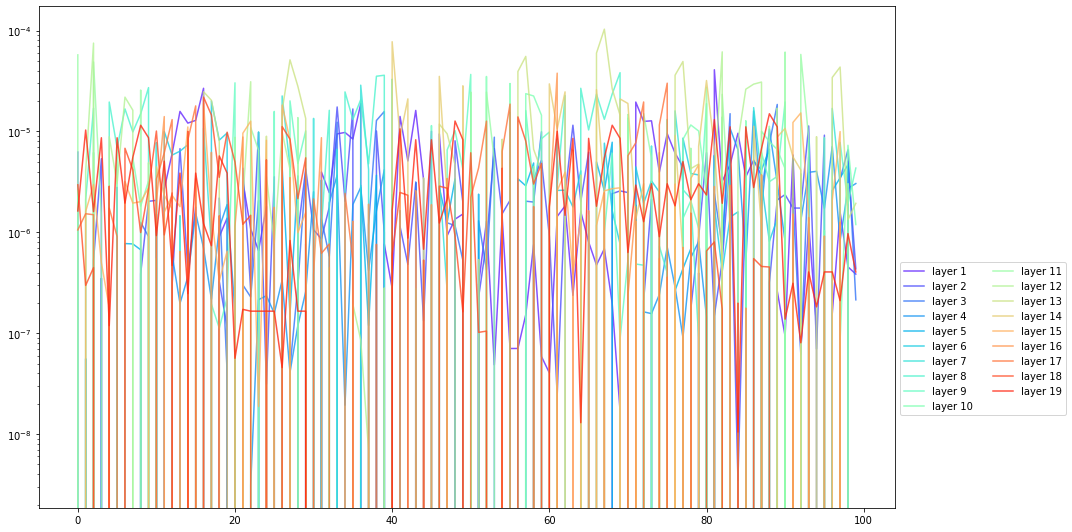

In [10]:
fig, ax = plt.subplots(figsize=(15, 7.5))
ax.set_yscale('log')
for grad_idx, grad in enumerate(gradients[::2]):
  if grad_idx >= 1:
    grad_abs = np.abs(grad.numpy().flat)
    ax.plot(grad_abs, label='layer {}'.format(grad_idx),
            color=cmap(grad_idx), alpha=0.8)
ax.legend(bbox_to_anchor=(1, 0.5), ncol=2)
fig.tight_layout()
plt.show()

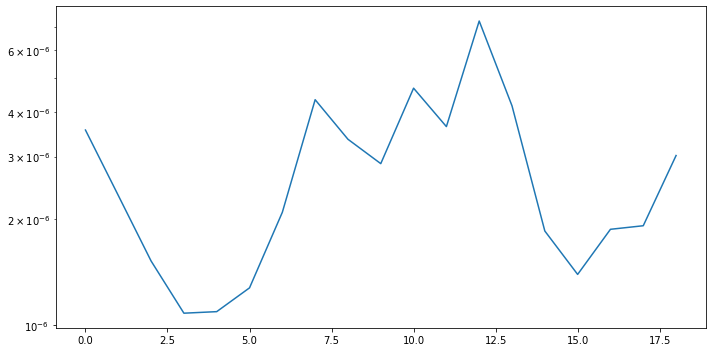

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_yscale('log')
grad_means = []
for grad_idx, grad in enumerate(gradients[::2]):
  if grad_idx >= 1:
    grad_abs = np.abs(grad.numpy().flat)
    grad_means.append(np.mean(grad_abs))
ax.plot(grad_means)
fig.tight_layout()
plt.show()